# LIBRARIES IMPORT

In [10]:
import CNN_lib
import CNN_utilities
import fig_lib 

import numpy as np
import matplotlib.pyplot as plt

import pickle
import json
import gc

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, classification_report


# SETTINGS

In [11]:
d_type='processed'                                         # 'processed', 'synthetic'
video_d=True                                               # Video = True , Image = False 

data_split='rnd_patients'                                      # 'rnd_recs' 'rnd_patients'
data_augmentation= True

checking_on=True
t_btw_frm=0.05
check_record= 'I70'

In [12]:
print('LIBRARY MODELS:')
print(' ')

for model_name in CNN_lib.MODELS.values(): print(model_name)

# -------- MODEL --------

model_from_CNN_lib,mdl= False,'video_conv3D'

opt='adam'
lss='binary_crossentropy'

# -------- TRAINNING --------

epochs=8

LIBRARY MODELS:
 
image_full
image_conv
image_conv_augmentation
video_conv2D
video_conv3D
conv3D_2D+1


### DATA SPLIT


In [13]:
if data_split == 'rnd_recs': test_size=0.2           

elif data_split == 'rnd_patients': val_pat_0,val_pat_1 = 10 , 5

### DATA AUGMENTATION

In [14]:
n_flip_1,n_flip_0=0.7 , 0.07

n_rot_1,n_rot_0=0.6 , 0.06

n_contr_1,n_contr_0=0.4 , 0.04

n_bright_1,n_bright_0=0.3 , 0.03

### PATHS

In [15]:
checkpoint_path = "C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static/model_checkpoint.h5"

if d_type=='processed' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/processed_train_d.pkl'  
elif d_type=='synthetic' : pkl_train_p='C:\PROJECTS\emboendo\CNN/pikles/synthetic_train_d.pkl'   

if data_split == 'rnd_patients': json_fix_sq_p='C:\PROJECTS\emboendo\dicom_viewer\_static\Jsons\points_fix_d.json'

# GENERATE TRAIN DATA

In [16]:
if data_split == 'rnd_patients':

    with open(json_fix_sq_p, 'r') as json_file:
        json_d = json.load(json_file)

    patients_d_df =  CNN_utilities.gen_patients_d_df(json_d)

In [17]:
with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train,rcs =  save_trains[0],save_trains[1],save_trains[2]

max_frm_n, HEIGHT, WIDTH=np.shape(x_train)[1],np.shape(x_train)[2],np.shape(x_train)[3]

### MODEL

In [18]:
if model_from_CNN_lib:
  
  if video_d: model = CNN_lib.lib_models(mdl,im_input_shp=(max_frm_n, HEIGHT, WIDTH, 1))
  else: model = CNN_lib.lib_models(mdl,im_input_shp=(HEIGHT, WIDTH,1))

else:

  input_shape=(max_frm_n, HEIGHT, WIDTH, 1)

  model = models.Sequential([
          layers.Conv3D(filters=16, kernel_size=(1, 3, 3), activation='relu',input_shape=input_shape),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=32, kernel_size=(1, 3, 3),  activation='relu'),
          layers.MaxPooling3D(pool_size=(2, 2, 2)),
          layers.Conv3D(filters=16, kernel_size=(5, 1, 1),  activation='relu'),
          layers.Flatten(),
          layers.Dropout(0.2),
          layers.Dense(64, activation='relu'),
          layers.Dense(1,activation='sigmoid')
          ])
  
model.compile(optimizer=opt, loss=lss, metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 40, 158, 158, 16   160       
                             )                                   
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 20, 79, 79, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_5 (Conv3D)           (None, 20, 77, 77, 32)    4640      
                                                                 
 max_pooling3d_4 (MaxPoolin  (None, 10, 38, 38, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_6 (Conv3D)           (None, 10, 36, 36, 32)    9248      
                                                     

In [19]:
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss',   mode='min', verbose=1)

### DATA INPUT CHECK 

In [20]:
if checking_on:

    for x,y,r in zip(x_train,y_train,rcs):print(r,int(y),np.shape(x),type(x))

I1 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I11 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I2 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I9 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I28 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I33 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I38 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I39 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I40 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I42 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I44 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I45 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I47 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I49 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I51 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I53 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I54 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I56 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I57 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I58 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I61 0 (40, 160, 160, 1) <class 'numpy.ndarr

I70  Label: 1


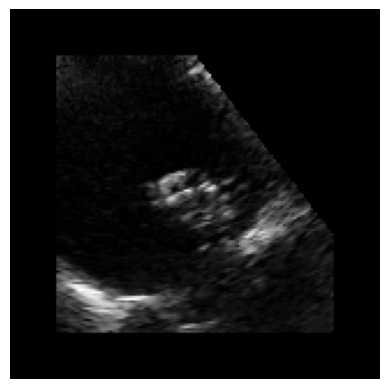

In [21]:
if checking_on: CNN_utilities.simple_check(check_record,rcs,x_train,y_train)

### DATA SHUFFLE 1

In [22]:
X_d,Y_d,recs=CNN_lib.shuffle(x_train,y_train,rcs)

# DATA SPLIT

In [23]:
if data_split=='rnd_recs': X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl ,recs_train,recs_eval=CNN_utilities.random_split_by_recs(X_d, Y_d,recs, test_size=test_size)                        
else: X_train_spl, X_eval_spl, Y_train_spl, Y_eval_spl ,recs_train,recs_eval=CNN_utilities.random_split_by_patients(patients_d_df,recs,X_d,Y_d, val_pat_0=val_pat_0, val_pat_1=val_pat_1)

print('Train data:',len(Y_train_spl),'Evaluation data:',len(Y_eval_spl))

Train data: 547 Evaluation data: 113


 Train data shape: (547, 40, 160, 160, 1)  Validation data shape: (113, 40, 160, 160, 1)


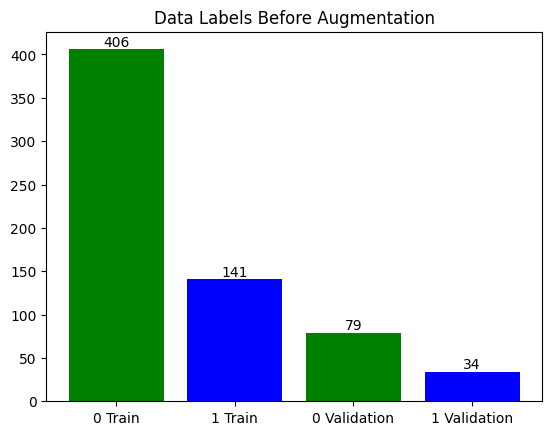

In [24]:
zeros_count = np.sum(Y_train_spl == 0)
ones_count = np.sum(Y_train_spl == 1)
zeros_count_val = np.sum(Y_eval_spl == 0)
ones_count_val = np.sum(Y_eval_spl == 1)

print(' Train data shape:', np.shape(X_train_spl),' Validation data shape:', np.shape(X_eval_spl))

CNN_lib.data_bars_plot(zeros_count,ones_count,zeros_count_val,ones_count_val)

### CHECK 2

In [25]:
if checking_on:

    print('----------TRAINS----------')
    for x,y,r in zip(X_train_spl,Y_train_spl,recs_train):
        print(r,int(y),np.shape(x),type(x))

    print('----------VALIDATION----------')
    for x,y,r in zip(X_eval_spl,Y_eval_spl,recs_eval):
        print(r,int(y),np.shape(x),type(x))

----------TRAINS----------
I481 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1144 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I72 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
547169_1 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
651399_1 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I42 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I915 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
6272_17 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I697 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I89 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I350 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I549 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I936 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I785 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I387 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
670615_9 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I394 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
669183_10 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I577 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1140 1 (40, 160, 160, 1

I70  Label: 1


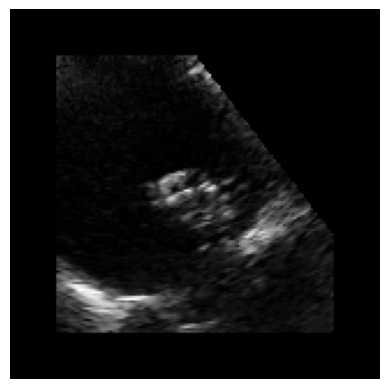

In [26]:
if checking_on: CNN_utilities.simple_check(check_record,recs_train,X_train_spl,Y_train_spl)        

# DATA AUGMENTATION

In [27]:
if data_augmentation:

    X_eval,Y_eval=X_eval_spl,Y_eval_spl
    X_train_spl, Y_train_spl, recs_train = CNN_lib.d_augmentation_logic_encapsulation(X_train_spl,Y_train_spl,recs_train,n_flip_1,n_flip_0,n_rot_1,n_rot_0,n_contr_1,n_contr_0,n_bright_1,n_bright_0)      # AUGMENTATION

    print(X_train_spl.shape,Y_train_spl.shape)
    print(X_eval_spl.shape,Y_eval_spl.shape)

(945, 40, 160, 160, 1) (945,)
(113, 40, 160, 160, 1) (113,)


### DATA SHUFFLE 2

In [28]:
if data_augmentation: X_train,Y_train,recs_train_f=CNN_lib.shuffle(X_train_spl,Y_train_spl,recs_train)
else: X_train,Y_train,recs_train_f = X_train_spl,Y_train_spl,recs_train

X_eval=X_eval_spl
Y_eval=Y_eval_spl

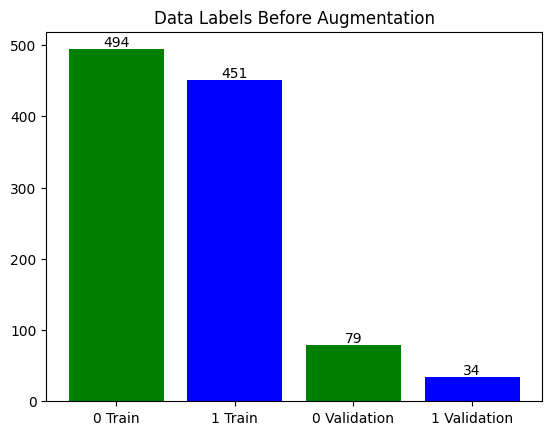

In [29]:
if data_augmentation:

    zeros_count = np.sum(Y_train == 0)
    ones_count = np.sum(Y_train == 1)
    zeros_count_val = np.sum(Y_eval == 0)
    ones_count_val = np.sum(Y_eval == 1)

    CNN_lib.data_bars_plot(zeros_count,ones_count,zeros_count_val,ones_count_val)

### CHECK 3

In [30]:
if checking_on:

    for x,y,r in zip(X_train,Y_train,recs_train_f):print(r,int(y),np.shape(x),type(x))

FLIP_I180 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
539258_1 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
FLIP_I177 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
BRGHT_I460 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
FLIP_670615_8 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I542 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I91 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I165 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
I1149 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_673676_15 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
CNTR_I189 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
272340_8 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
FLIP_I551 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
178572_4 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_539258_1 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
I259 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
547169_8 0 (40, 160, 160, 1) <class 'numpy.ndarray'>
FLIP_669183_10 1 (40, 160, 160, 1) <class 'numpy.ndarray'>
ROT_I1065 0 (40, 160, 160, 1) <class

I70  Label: 1.0


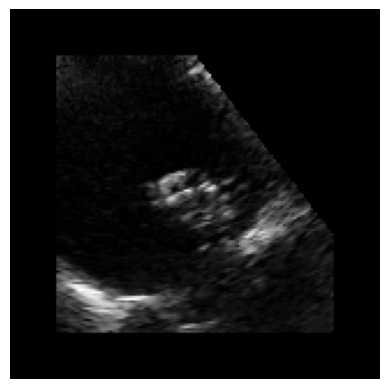

In [31]:
if checking_on: CNN_utilities.simple_check(check_record,recs_train_f,X_train,Y_train)      

#  CNN TRAINNING

In [32]:
history =model.fit(X_train, Y_train, epochs=epochs, validation_data=(X_eval,Y_eval),callbacks=[checkpoint])

Epoch 1/8


30/30 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.5302
Epoch 1: val_loss improved from inf to 0.72158, saving model to C:/PROJECTS\emboendo\CNN\python-machine-learning\emboendo_ML\embo_CNN_lab\_static\model_checkpoint.h5
30/30 [==============================] - 18s 570ms/step - loss: 0.6894 - accuracy: 0.5302 - val_loss: 0.7216 - val_accuracy: 0.3717
Epoch 2/8


c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - ETA: 0s - loss: 0.6222 - accuracy: 0.6571
Epoch 2: val_loss did not improve from 0.72158
30/30 [==============================] - 16s 533ms/step - loss: 0.6222 - accuracy: 0.6571 - val_loss: 0.8942 - val_accuracy: 0.3540
Epoch 3/8
30/30 [==============================] - ETA: 0s - loss: 0.5383 - accuracy: 0.7291
Epoch 3: val_loss did not improve from 0.72158
30/30 [==============================] - 16s 529ms/step - loss: 0.5383 - accuracy: 0.7291 - val_loss: 0.7444 - val_accuracy: 0.6637
Epoch 4/8
30/30 [==============================] - ETA: 0s - loss: 0.4782 - accuracy: 0.7619
Epoch 4: val_loss did not improve from 0.72158
30/30 [==============================] - 16s 536ms/step - loss: 0.4782 - accuracy: 0.7619 - val_loss: 0.8447 - val_accuracy: 0.5044
Epoch 5/8
30/30 [==============================] - ETA: 0s - loss: 0.4034 - accuracy: 0.8212
Epoch 5: val_loss did not improve from 0.72158
30/30 [==============================] - 16s 533ms/ste

### EVALUATE MODEL

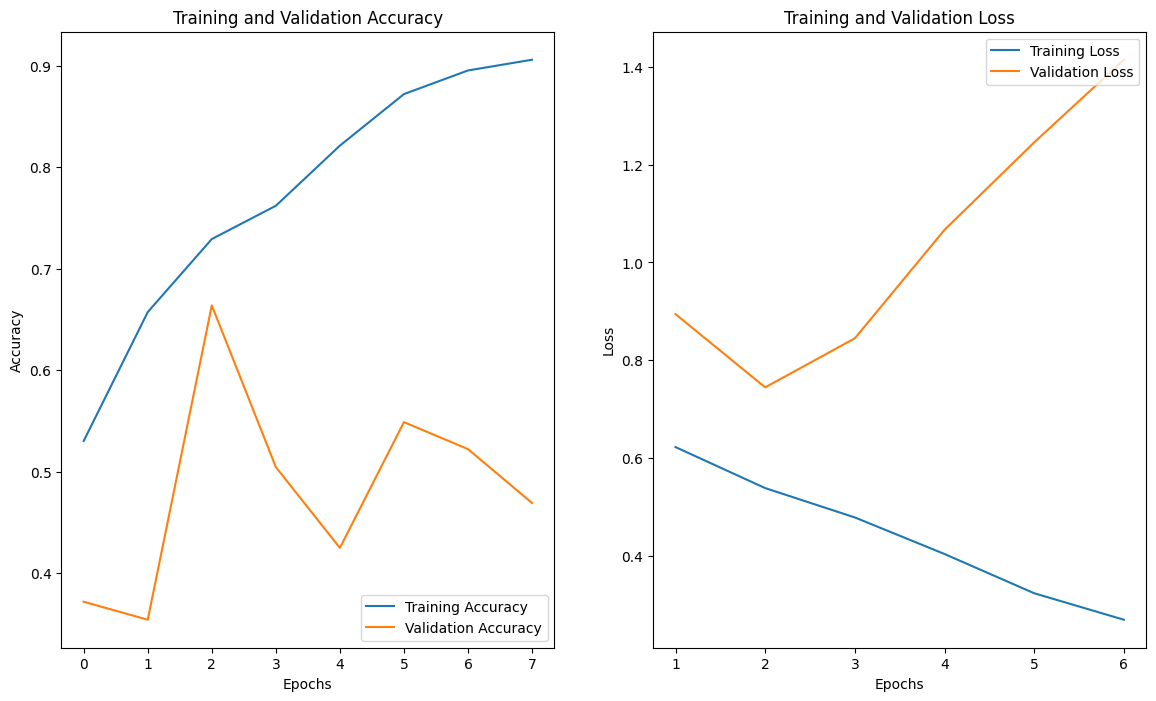

In [33]:
CNN_lib.plot_train_eval(history,epochs)

In [34]:
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)

print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

4/4 - 1s - loss: 1.5334 - accuracy: 0.4690 - 534ms/epoch - 133ms/step
Loss: 1.5333536863327026 Accuracy: 0.4690265357494354


In [35]:
model = load_model(checkpoint_path)
test_loss, test_accuracy = model.evaluate(X_eval,Y_eval,verbose=2)
print(f'Loss: {test_loss}',f'Accuracy: {test_accuracy}')

4/4 - 1s - loss: 0.7216 - accuracy: 0.3717 - 619ms/epoch - 155ms/step
Loss: 0.7215823531150818 Accuracy: 0.37168142199516296


In [36]:
performance_d={'NAME':mdl, 'ACCURACY':test_accuracy, 'LOSS':test_loss, 'HEIGHT':HEIGHT,'WIDTH':WIDTH}

performance_d

{'NAME': 'video_conv3D',
 'ACCURACY': 0.37168142199516296,
 'LOSS': 0.7215823531150818,
 'HEIGHT': 160,
 'WIDTH': 160}

# VALIDATION DATA

In [37]:
predictions = model.predict(X_eval)
#print(predictions)

4/4 [==============================] - 1s 122ms/step


## ROC CURVE

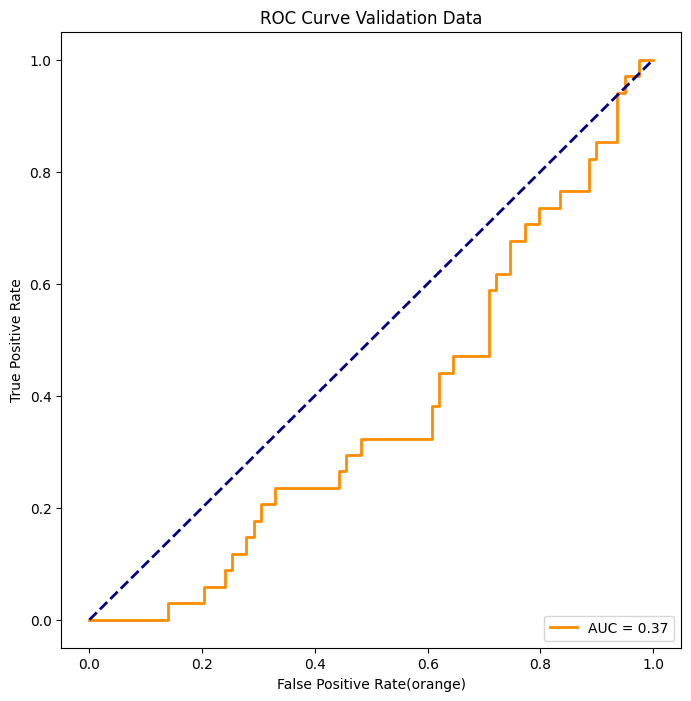

In [38]:
fpr_val, tpr_val, thresholds_val = roc_curve(Y_eval, predictions)
roc_auc_false = auc(fpr_val, tpr_val)

CNN_lib.plot_roc_curve(fpr_val,tpr_val,roc_auc_false)

#  FORECAST EVALUATION

In [39]:
predictions_raw=[]

trsh=0.35

for pred in predictions:

    if pred < trsh:predictions_raw.append(0)
    else:predictions_raw.append(1)

predictions_raw=np.array(predictions_raw)


In [40]:
conf_matrix = confusion_matrix(Y_eval, predictions_raw)

print("Matriz de Confusión:")
print(conf_matrix)

# Obtener el informe de clasificación
classification_report_str = classification_report(Y_eval, predictions_raw)
print("Informe de Clasificación:")
print(classification_report_str)



Matriz de Confusión:
[[ 0 79]
 [ 0 34]]
Informe de Clasificación:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        79
           1       0.30      1.00      0.46        34

    accuracy                           0.30       113
   macro avg       0.15      0.50      0.23       113
weighted avg       0.09      0.30      0.14       113



c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\PROJECTS\EMBOENDO\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
true_classes = Y_eval  

correctly_classified_idx = np.where(predictions_raw == true_classes)[0]
incorrectly_classified_idx = np.where(predictions_raw != true_classes)[0]

correctly_classified_video_ids = [video_id for video_id in correctly_classified_idx]
incorrectly_classified_video_ids = [video_id for video_id in incorrectly_classified_idx]

num_zeros = np.count_nonzero(Y_eval == 0)
num_ones = np.count_nonzero(Y_eval == 1)


In [42]:
correct_labels_val = [Y_eval[i] for i in correctly_classified_idx]

print(correct_labels_val)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [43]:

print(f"OK, {len(correctly_classified_video_ids)}")
print(f"BAD, {len(incorrectly_classified_video_ids)}")
print(f'Ratio forecast: {len(correctly_classified_video_ids)/len(incorrectly_classified_video_ids)}')
print(f'Ratio labeling: {max([num_ones,num_zeros])/min([num_ones,num_zeros])}')


OK, 34
BAD, 79
Ratio forecast: 0.43037974683544306
Ratio labeling: 2.323529411764706


## SINGLE FORECAST

In [44]:
print(recs_eval)

['I51', 'I53', 'I54', 'I56', 'I57', 'I58', 'I61', 'I63', 'I64', 'I65', 'I66', 'I67', 'I230', 'I238', 'I240', 'I263', 'I264', 'I265', 'I266', 'I267', 'I268', 'I269', 'I270', 'I278', 'I281', 'I286', 'I408', 'I409', 'I411', 'I414', 'I416', 'I417', 'I418', 'I578', 'I584', 'I588', 'I592', 'I593', 'I1040', 'I1041', 'I1042', 'I1045', 'I1046', 'I1054', 'I1055', 'I1057', '380772_1', '380772_10', '380772_11', '380772_12', '380772_13', '380772_2', '380772_3', '380772_4', '380772_5', '380772_6', '380772_7', '380772_8', '380772_9', '415001_1', '415001_2', '415001_3', '415001_7', '656335_1', '656335_2', '656335_3', '656335_4', '656335_5', '656335_6', '656335_7', '656335_8', '109897_1', '109897_2', '109897_3', '109897_4', '109897_5', '109897_6', '109897_7', '109897_9', 'I851', 'I854', 'I855', 'I1000', 'I1001', 'I1002', 'I1003', 'I1005', 'I1018', 'I1021', 'I1022', 'I1024', 'I1025', 'I1027', 'I996', 'I999', 'I1078', 'I1088', 'I1244', 'I1247', 'I1248', 'I1254', 'I1258', 'I1259', 'I1264', 'I1266', 'I1268

In [45]:
rec_elm='I765'
idx=recs_eval.index(rec_elm)

print(f' Record: {rec_elm} , index: {idx}, real label: {Y_eval_spl[idx]}')

ValueError: 'I765' is not in list

In [ ]:
if checking_on:fig_lib.vid_show(X_eval[idx],t_btw_frm=t_btw_frm)

In [ ]:
nuevo_video = np.expand_dims(X_eval[idx], axis=0)

prediccion = model.predict(nuevo_video)
prediccion